# Serie temporal como feature

## ¿Qué es dependencia serial?

Ya conocemos las propiedades de las series temporales que se modelan más fácilmente como propiedades *dependientes del tiempo*, es decir, con features que podíamos derivar directamente del índice del tiempo. Sin embargo, algunas propiedades de las series temporales solo se pueden modelar como propiedades *dependientes serialmente*, es decir, usando como features valores pasados de la serie objetivo. La estructura de estas series temporales puede no ser evidente en un gráfico de tiempo; sin embargo, dibujada contra valores pasados, la estructura se vuelve clara, como vemos la figura siguiente.

![serial_dependence](./images/serial_dependence.png)

Estas dos series tienen dependencia serial, pero no dependencia de tiempo. Los puntos de la parte derecha tiene coordenadas (`valor en el tiempo t-1, valor en el tiempo t`).

Con la tendencia y la estacionalidad, entrenamos modelos para ajustar curvas a gráficos como estos de la izquiera de la figura anterior, donde los modelos aprendían la dependencia de tiempo. El objetivo en este caso es entrenar modelos para ajustar curvas a gráficos como los de la derecha, donde lo que queremos es aprender dependencias seriales.

### Ciclos

Una forma especialmente común en la que se manifiesta la dependencia serial es en los **ciclos**. Los ciclos son patrones de crecimiento y decrecimiento en una serie temporal asociados a cómo los valores de una serie en un momento dependen de los valores del momento anterior, pero no necesariamente del paso de tiempo en sí. El comporamiento cíclico es característico de los sistemas que pueden afectarse a sí mismos o cuyas reacciones persisten en el tiempo. Las economías, las epidemias, las poblaciones animales, las erupciones volcánicas y otros fenómenos naturales similares suelen mostrar comportamientos cíclicos. En la figura siguiente se pueden observar cuatro series temporales con comportamiento cíclico.

![comportamiento_ciclico](./images/comportamiento_ciclico.png)

Lo que distingue el comportamiento cíclico de la estacionalidad es que los ciclos no son necesariamente dependientes del tiempo, como lo es la estacionalidad. Lo que sucede en un ciclo tiene menos que ver con la fecha en particular de ocurrencia y más con lo que sucedió en el pasado reciente. La, al menos relativa, independencia del tiempo significa que el comportamiento cíclico puede ser mucho más irregular que la estacionalidad.

## Series demoradas y gráficos de lag

Para investivar la posible dependencia serial (como ciclos) en una serie temporal, necesitamos crear copias "demoradas" (*lagged*) de la serie. Demorar o **lagging** una serie temporal significa deslizar/desplazar sus valores hacia adelante uno o más pasos de tiempo, o de forma equivalente, desplazar los tiempos de su índice hacia atrás uno o más pasos de tiempo. En cualquier caso, el efecto es que las observaciones en las serie lagged parecen haber sucedido más tarde en el tiempo.

La siguiente tabla muestra la tasa de desempleo mensual en EEUU (`y`) junto con sus primera y segunda serie lagged (`y_lag_1`) y (`y_lag_2`), respectivamente. Observemos que los valores de las series lagged se desplazan hacia adelante en el tiempo.

In [130]:
import pandas as pd

# dataset de la reserva federal: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "../data/reserve.csv",
    parse_dates={"Date": ['Year', 'Month', 'Day']},
    index_col="Date",
)

y = reserve.loc[:, "Unemployment Rate"].dropna().to_period('M')
df = pd.DataFrame({
    "y": y,
    "y_lag_1": y.shift(1),
    "y_lag_2": y.shift(2),
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


Con el lagging de una serie temporal podemos hacer que sus valores pasados parezcan contemporáneos con los valores que intentamos predecir (en la misma fila, en otras palabras). Esto hace a las series lagged útiles como features para modelar la dependencia serial. Para pronosticar la serie de tasa de desempleo en EEUU, podríamos usar `y_lag_1` e `y_lag_2` como features para predecir el objetivo `y`. Esto pronosticaría la futura tasa de desempleo en función de la tasa de desempleo de los dos meses anteriores.

### Gráficos de lag

Un gráfico de lag de una serie temporal muestra sus valores dibujados contra sus lag's. La dependencia serial en una serie temporal a menudo se hace evidente mirando un gráfico de lag. Podemos ver en el gráfico de lag de este dataset que hay una relación fuerte y aparentemente lineal entre la tasa de desempleo actual y las tasas pasadas.

![lag_plot](./images/lag_plot_us.png)

La medida más comúnmente usada de dependencia serial es la **[autocorrelación](https://es.wikipedia.org/wiki/Autocorrelaci%C3%B3n)**, que es simplemente la correlación que una serie temporal tiene con uno de sus lag's. En este dataset, la tasa de desempleo de EEUU tiene una autocorrelación de 0.99 en el lag 1, 0.98 en el lag 2, y así sucesivamente.

### Elegir el lag

Generalmente, cuando elegimos lag's para usarlos como features, no será útil incluir *cada* lag con una gran autocorrelación. En cuanto al desempleo de EEUU, por ejemplo, la autocorrelación en el lag 2 podría resultar completamente de información "descompuesta" del lag 1, solo correlación que se transfiere del paso anterior. Si el lag 2 no contiene nada nuevo, no habría razón para incluirlo si ya disponemos del lag 1.

La **autocorrelación parcial** nos dice la correlación de un lag teniendo en cuenta todos los lag's previos, por así decirlo la cantidad de correlación "nueva" que aporta el lag. Dibujar la autocorrelación parcial puede ayudar a elegir qué feature de lag usar. En la siguiente figura, el lag 1 hasta el lag 6 caen fuera del intervalo de "no correlación" (en azul), por lo que podríamos esos 6 lag's como features para el dataset de desempleo de EEUU. (El lag 11 es probablemente un falso positivo).

![partial_correlation](./images/partial_correlation.png)

La figura muestra las autocorrelaciones parciales de desempleo EEUU hasta el lag 12 con intervarlos de confianza del 95% de no correlación.

Un gráfico como el anterior se denomina *[correlograma](https://es.wikipedia.org/wiki/Correlograma)*. El correlograma es a las features lag lo que el periodograma es a las features Fourier.

Finalmente, debemos tener en mente que la autocorrelación y la autocorrelación parcial son medidas de la dependencia *lineal*. Debido a que las series temporales del mundo real suelen tener dependencias no lineales sustancialmente, es mejor mirar un gráfico de lag (o usar alguna medida general de dependiencia, como [información mutua](https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial)) al elegir features lag. La serie *Sunspots* tiene lag's con dependencia no lineal que podríamos ignorar con la autocorrelación.

![lag_plot_sunspot](./images/lag_plot_sunspot.png)

Las relaciones no lineales como esta pueden ser transformadas para ser lineales o aprenderse con un algoritmo apropiado.

## Ejemplo - Tendencias gripe

El dataset de *Tendencias gripe* contiene registros de consultas médicas por la gripe durante semanas de 2009 a 2016. Nuestro objetivo es predecir el número de casos de gripe para las próximas semanas.

Tomaremos dos enfoques. En el primero predeciremos las consultas médicas usando features lag. El segundo enfoque será predecir las consultas médicas usando lag's de *otro* conjunto de series temporales: términos de búsqueda relacionados con la gripe capturados por Google Trends.

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

In [132]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [133]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [134]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [135]:
flu_trends = pd.read_csv("../data/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


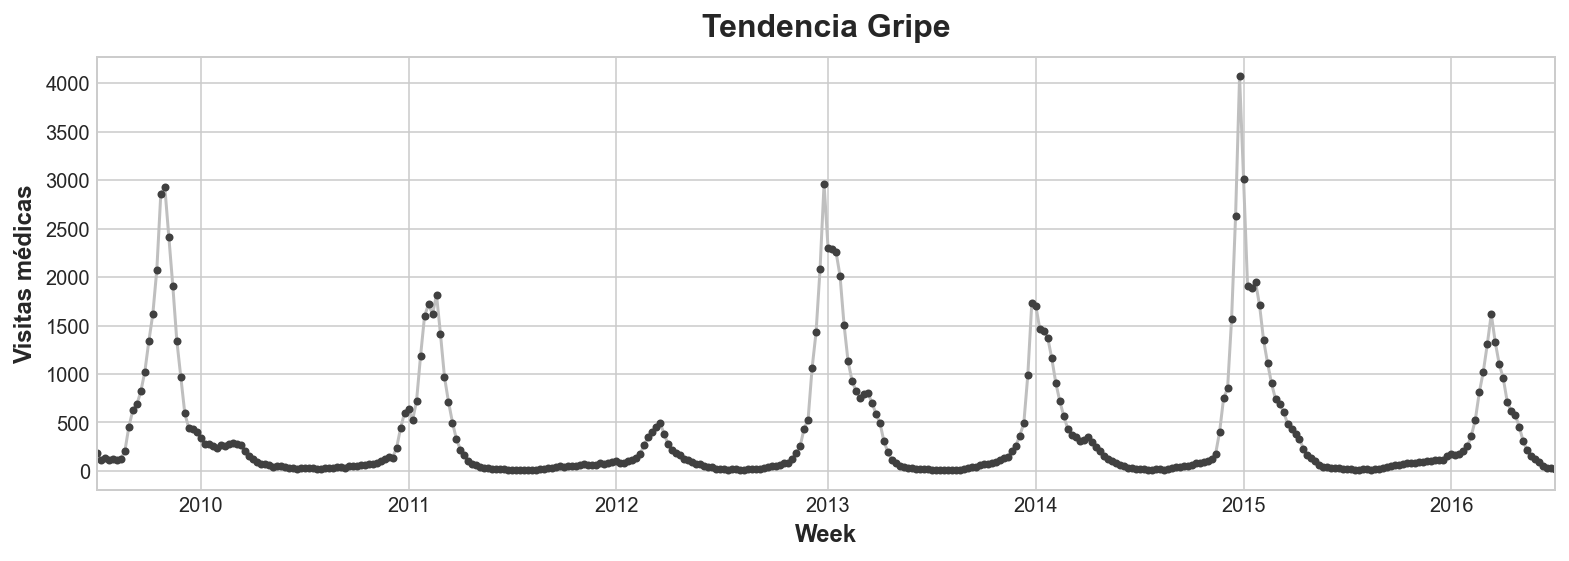

In [136]:
ax = flu_trends.FluVisits.plot(title='Tendencia Gripe', **plot_params)
_ = ax.set(ylabel="Visitas médicas")

Nuestros datos de *Tendencias Gripe* muestran ciclos irregulares en lugar de una estacionalidad regular: el pico tiende a ocurrir alrededor del año nuevo, pero algunas veces antes o después, a veces más grande o más pequeño. Modelar estos ciclos con features lag permitirá a nuestras predicciones reaccionar dinámicamente a condiciones cambiantes en lugar de estar restringidas a fechas y horas exactas como las features estacionales.

En primer lugar, echemos un vistazo a los gráficos de lag y autocorrelación:

C:\Program Files\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


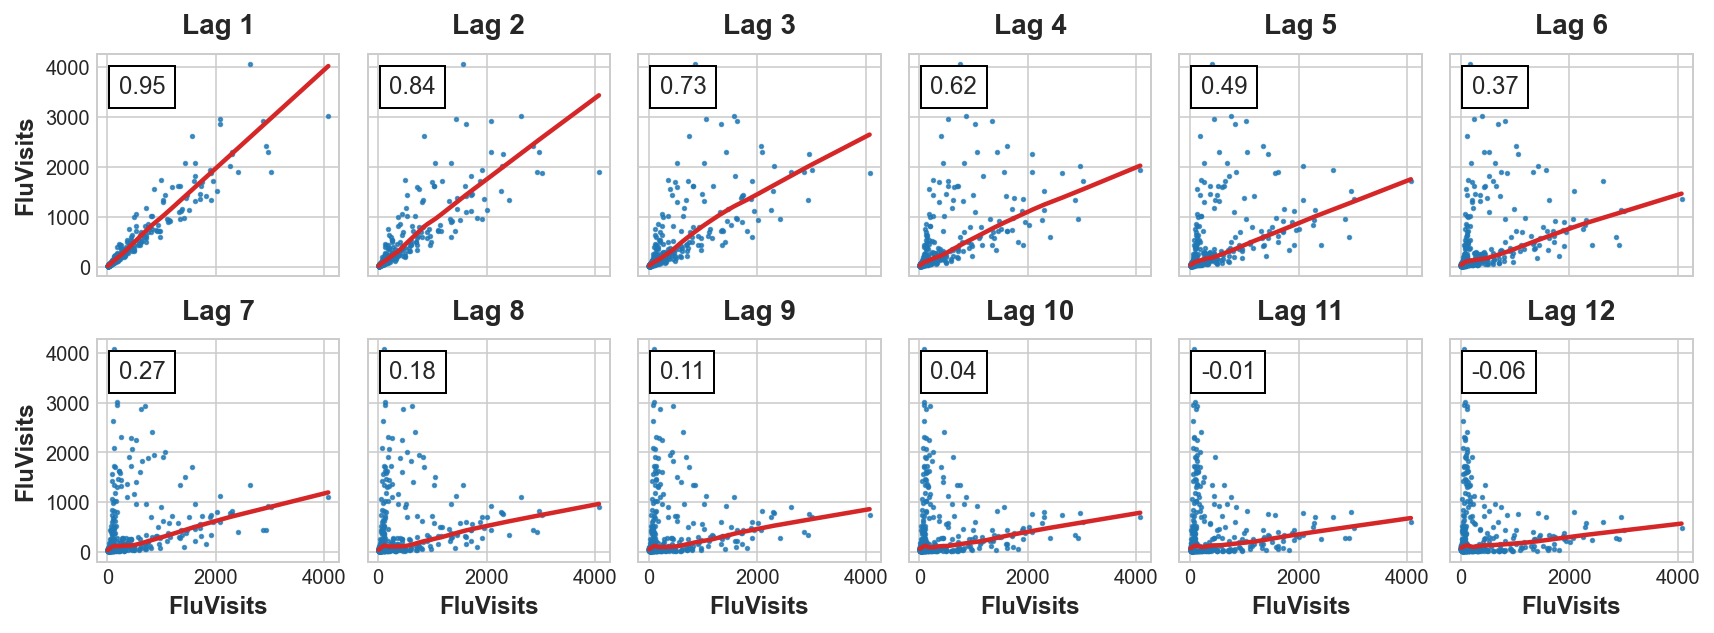

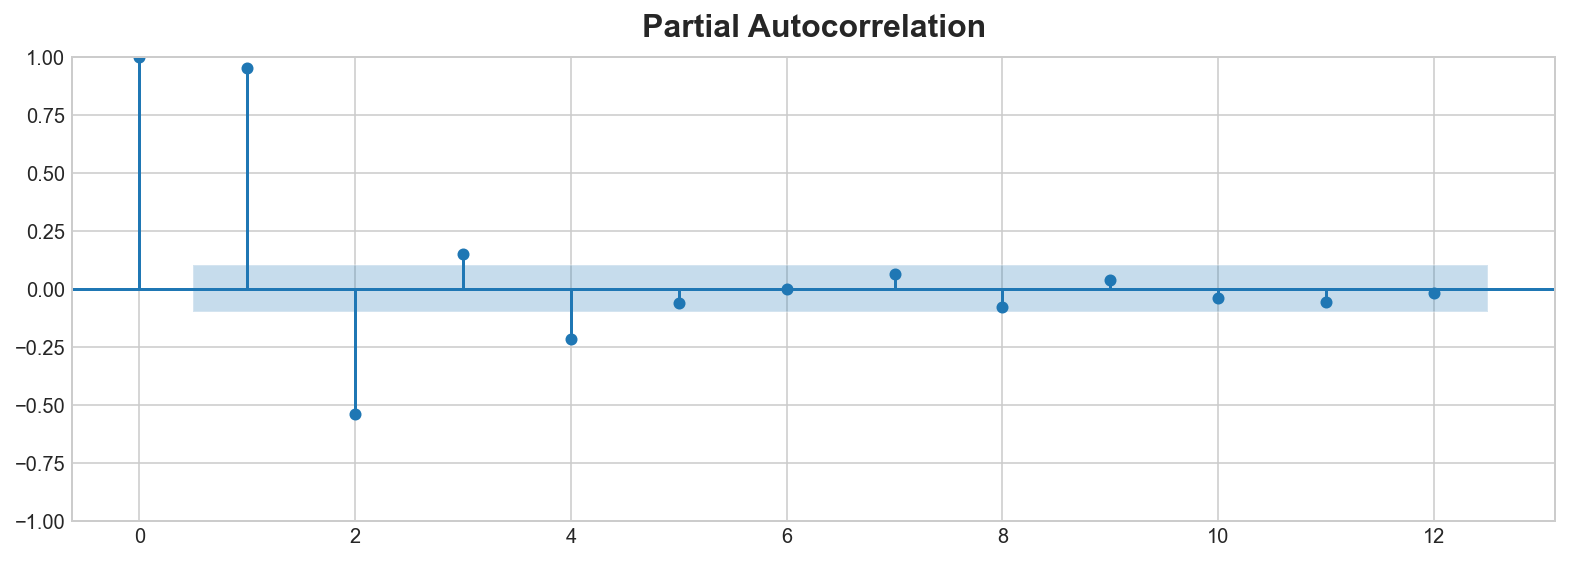

In [137]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

El gráfico de lag indica que la relación de `FluVisits` con sus lag's es mayormente lineal, mientras que el gráfico de autocorrelación sugiere que la dependencia puede ser capturada usando lag 1, 2, 3 y 4. En Pandas podemos crear features lag con el método `shift`. Para este problema, rellenaremos los datos faltantes que genera el lagging con `0.0`.

In [138]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [139]:
X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


Cuando usamos features lag estamos limitados a pronosticar pasos de tiempo cuyos valores lagged estén disponibles. Usando una feature lag 1 para lunes, no podemos predecir el miércoles porque el valor necesario de lag 1 es el martes, que aún no ha sucedido. Ya veremos posteriormente estrategias para manejar este problema. Ahora solo usaremos valroes de un conjunto de prueba.

In [140]:
# Crea la serie objetivo y divide los datos
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Entrena y predice
model = LinearRegression()  # `fit_intercept=True` dado que no usamos DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

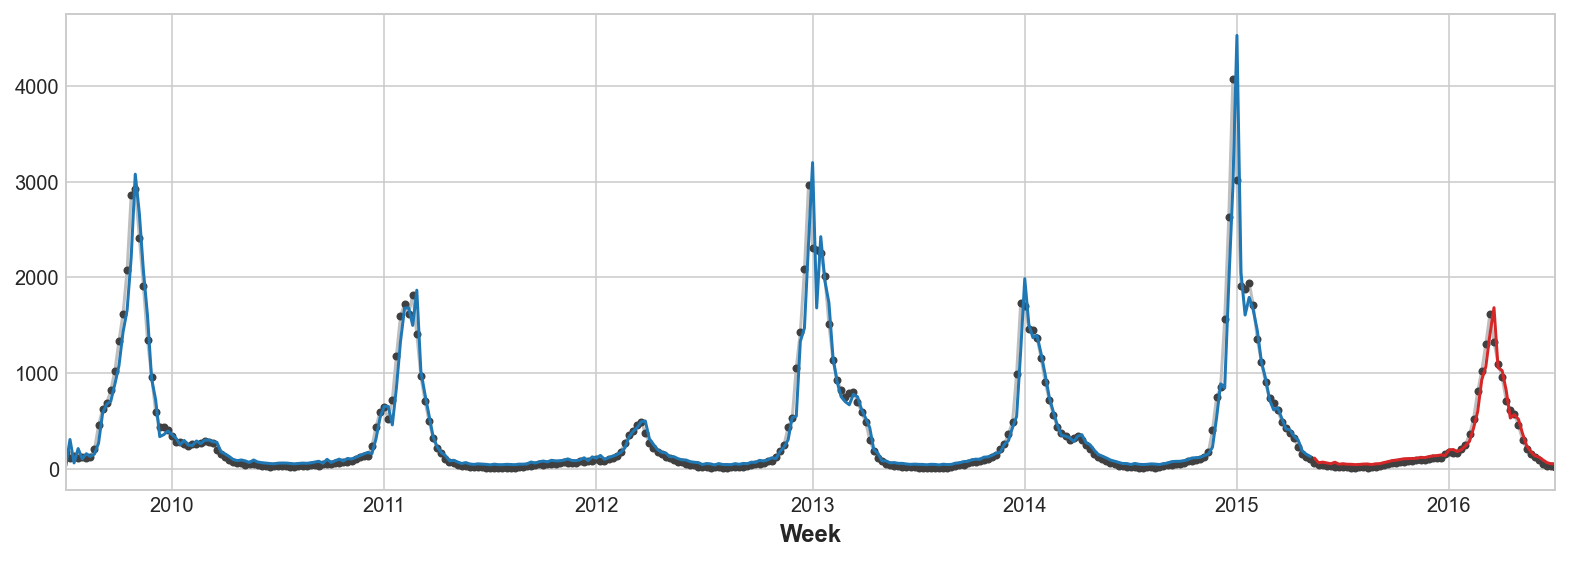

In [141]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

Mirando solo los valores de predicción, podemos ver cómo nuestro modelo necesita un paso de tiempo para reaccionar a cambios repentinos en la serie objetivo. Esta es una limitación común de los modelos que usan solo lag's de la serie objetivo como features.

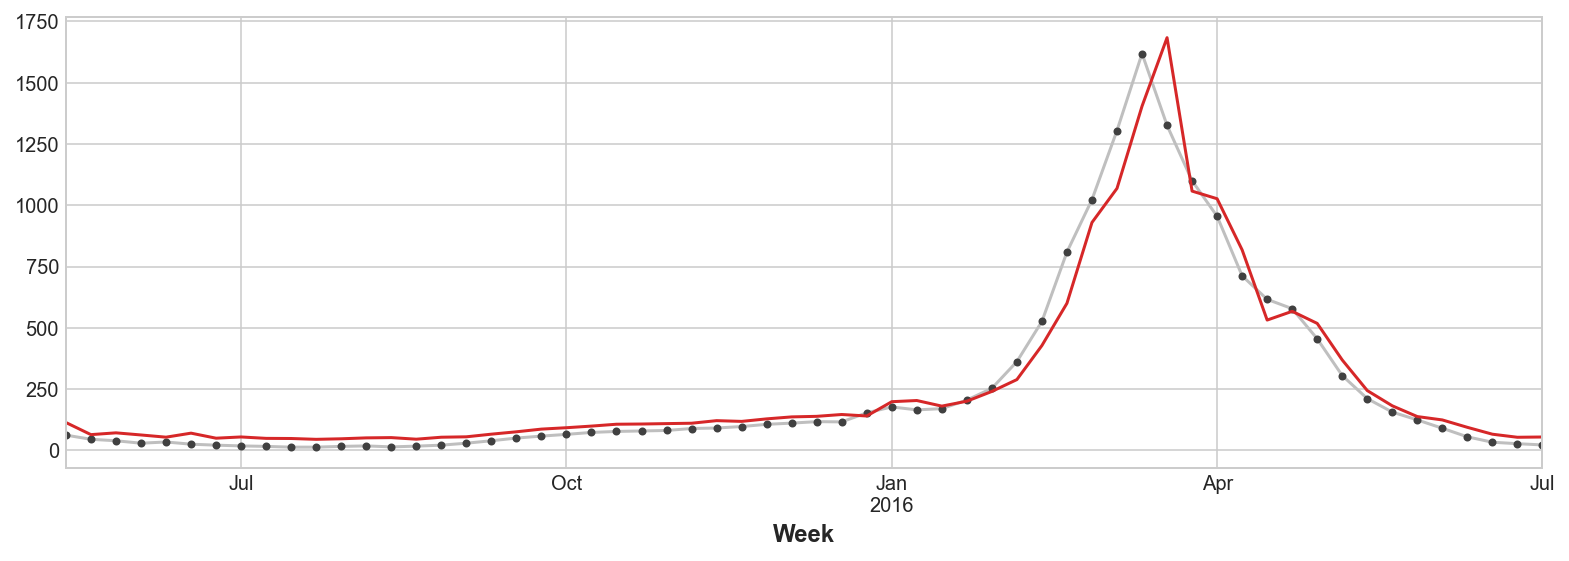

In [142]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Para mejorar la predicción, podríamos intentar encontrar *indicadores adelantados* (*leading indicators*), series temporales que pudieran proporcionar una "alerta temprana" para cambios en los casos de gripe. Para nuestro segundo enfoque añadiremos a nuestros datos de entrenamiento datos de la popularidad de algunos términos de búsqueda relacionados con la gripe según lo medido por Google Trends.

Dibujar la frase de búsqueda `"FluCough"` contra el objetivo `"FluVisits"` sugiere que tales términos podrían ser útiles como indicadores adelantados: las búsquedas relacionadas con la gripe tienden a ser más populares en las semanas anteriores a las visitas médicas.

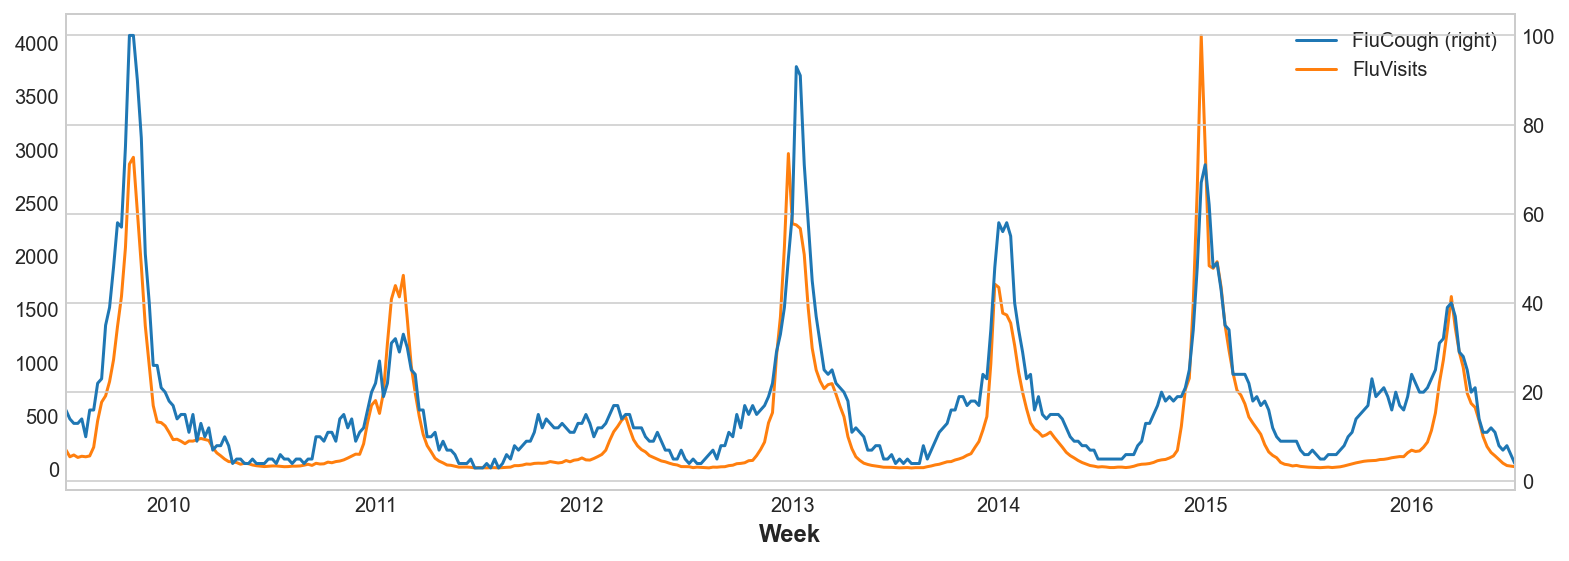

In [143]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

El dataset contiene 219 de tales términos, pero solo usaremos unos pocos.

In [144]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Crea tres lag's para cada término de búsqueda
X0 = make_lags(flu_trends[search_terms], lags=3)

# Crea cuatro lag's para el objetivo, como antes
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combina para crar los datos de entrenamiento
X = pd.concat([X0, X1], axis=1).fillna(0.0)

X.head()

,"(y_lag_1, FluContagious)","(y_lag_1, FluCough)","(y_lag_1, FluFever)","(y_lag_1, InfluenzaA)","(y_lag_1, TreatFlu)","(y_lag_1, IHaveTheFlu)","(y_lag_1, OverTheCounterFlu)","(y_lag_1, HowLongFlu)","(y_lag_2, FluContagious)","(y_lag_2, FluCough)",...,"(y_lag_3, FluFever)","(y_lag_3, InfluenzaA)","(y_lag_3, TreatFlu)","(y_lag_3, IHaveTheFlu)","(y_lag_3, OverTheCounterFlu)","(y_lag_3, HowLongFlu)",y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,6.0,13.0,13.0,24.0,8.0,8.0,7.0,7.0,6.0,14.0,...,15.0,36.0,6.0,5.0,11.0,6.0,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,5.0,13.0,12.0,23.0,5.0,4.0,6.0,6.0,6.0,13.0,...,15.0,25.0,12.0,7.0,7.0,7.0,109.0,132.0,115.0,180.0


Nuestras predicciones son un poco más aproximadas, pero nuestro modelo parece ser más capaz de anticipar incrementos repentinos en las consultas médicas, lo que sugiere que las diversas series temporales de búsqueda de popularidad han sido, de hecho, efectivas como indicadores adelantados.

C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


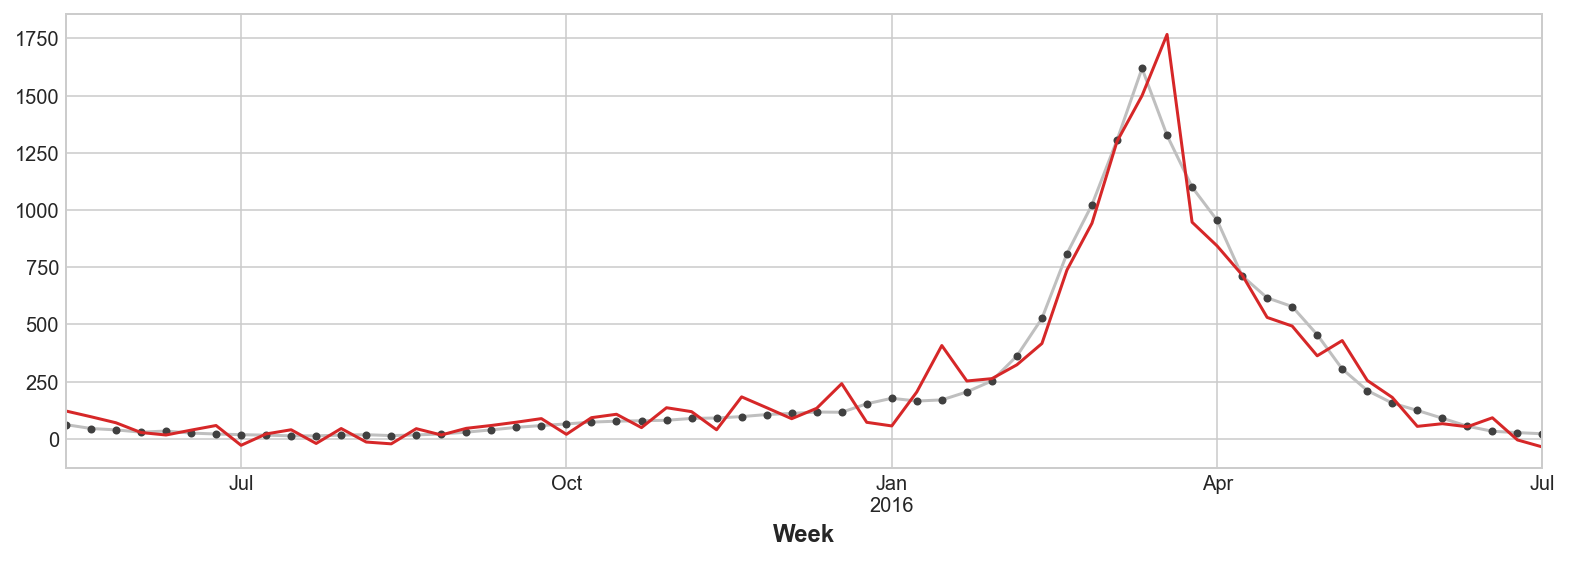

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Las series temporales que hemos visto aquí son lo que se podrían llamar "puramente cíclicas": no tienen una tendencia o estacionalidad obvias. Sin embargo, no es raro que las series temporales posean tendencias, estacionalidad y ciclos, los tres componentes a la vez. Podríamos modelar tales series con regresión lineal simplemente añadiendo las features apropiadas para cada componente. Incluso podemos combinar modelos entrenados para aprender los componentes por separado, que ya veremos con las predicciones híbridas.

# Ejercicio

Vamos a realizar un ejercicio para ampliar lo que acabamos de ver.

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [147]:
from helpers.style import * # importa estilos de gráficos
from helpers.utils import plot_lags, make_lags, make_leads

In [148]:
store_sales = pd.read_csv(
    "../data/store_sales/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [149]:

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

No todas las familias de productos tiene ventas que muestren comportamientos cíclicos y tampoco la serie de ventas promedio. Sin embargo, las ventas de material escolar y de oficina muestran patrones de crecimiento y decrecimiento que no están bien caracterizados por tendencias o estaciones. Vamos a modelar ciclos en las ventas de este tipo de este material usando features lag.

Tanto la tendencia como la estacionalidad crearán una dependencia serial que mostrarán se mostrará en los gráficos de correlograma y de lag. Para aislar cualquier comportamiento puramente *cíclico*, empezaremos desestacionalizando la serie.

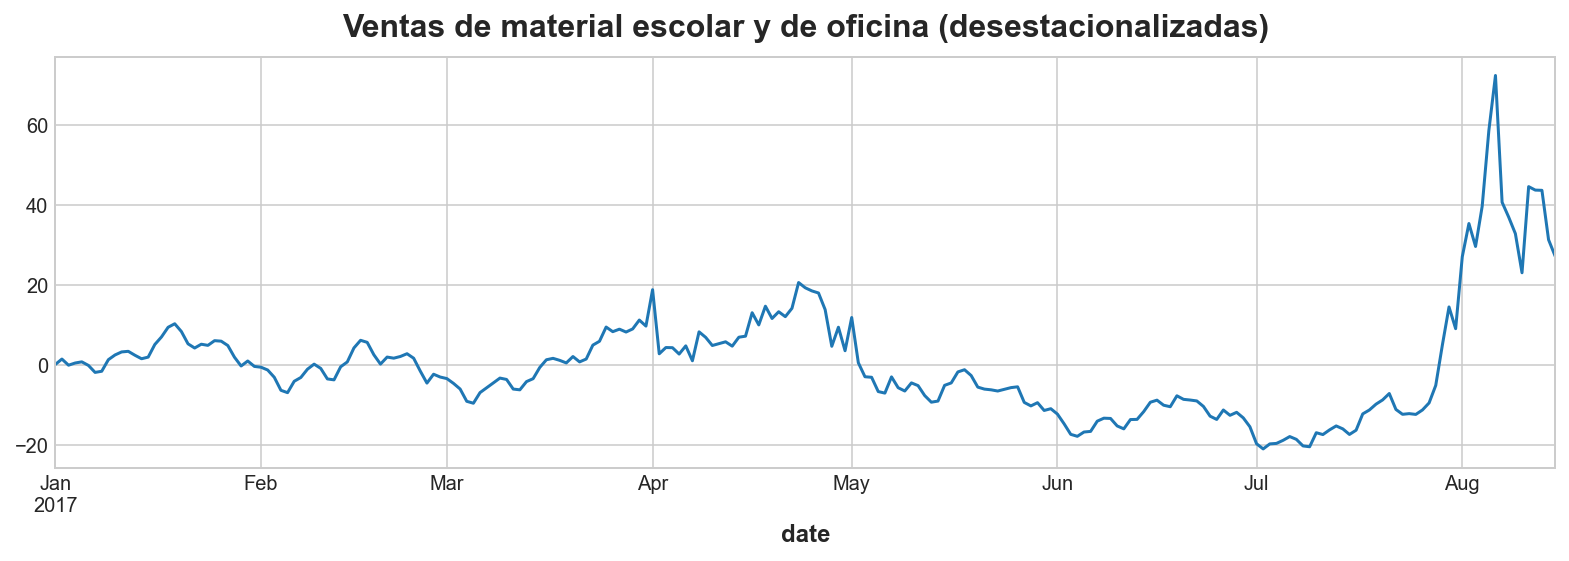

In [150]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Ventas de material escolar y de oficina (desestacionalizadas)");

¿Esta serie desestacionalizada muestra patrones cíclicos? Para confirmar nuestra intuición, podemos intentar aislar el comportamiento cíclico usando un gráfico de media móvil como se hace con la tendencia. La idea es elegir una ventana lo suficientemente grande para suavizar la estacionalidad a corto plazo, pero lo suficientemente pequeña para preservar los ciclos.

## Dibujando ciclos

Vamos a crear una media móvil de siete días de `y`, la serie de venta de materiales. Usaremos una ventana centrada, pero no estableceremos el argumento `min_periods`.

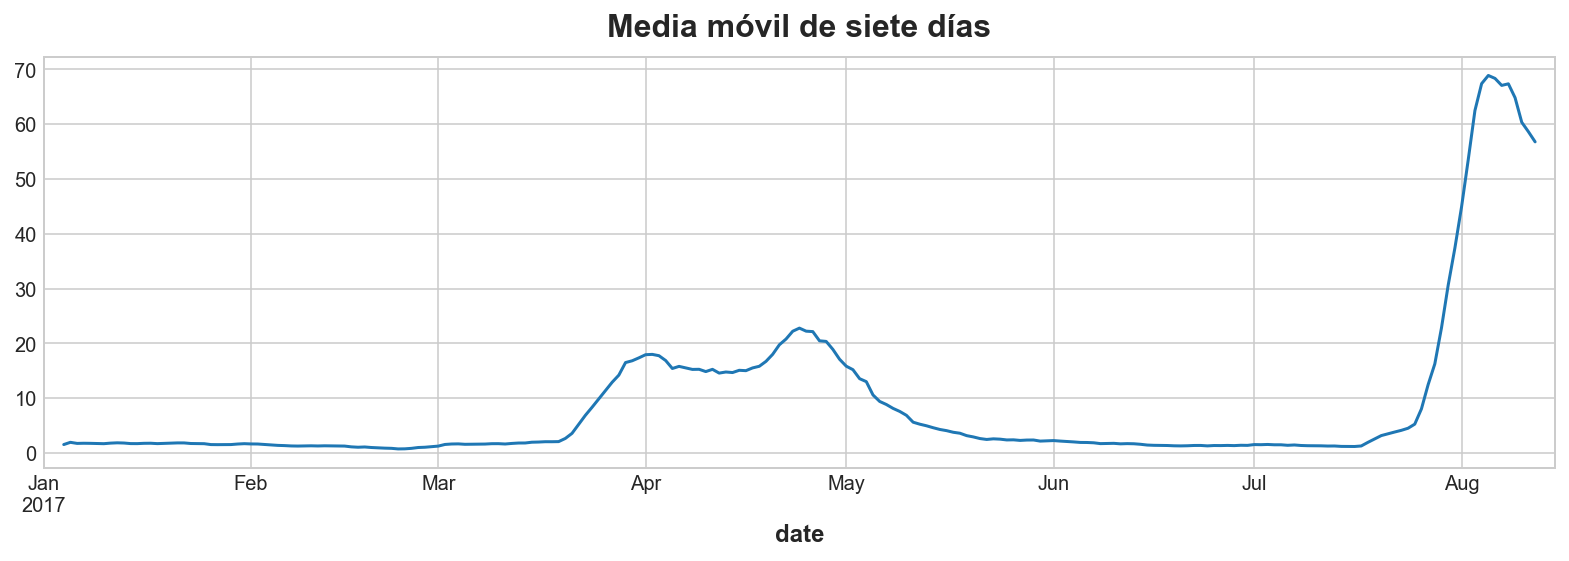

In [151]:
y_ma = y.rolling(
    window=7,
    center=True,
).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Media móvil de siete días");

¿Vemos como la trama de la media móvil se parece al gráfico de la serie desestacionalizada? En ambos casos se puede observar el comportamiento cíclico indicado.

## Examinando la dependencia serial

Vamos a examinar nuestra serie desestacionalizada para determinar la dependencia serial. Echaremos un vistazo al correlograma de autocorrelación parcial y al gráfico de lag.

C:\Program Files\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


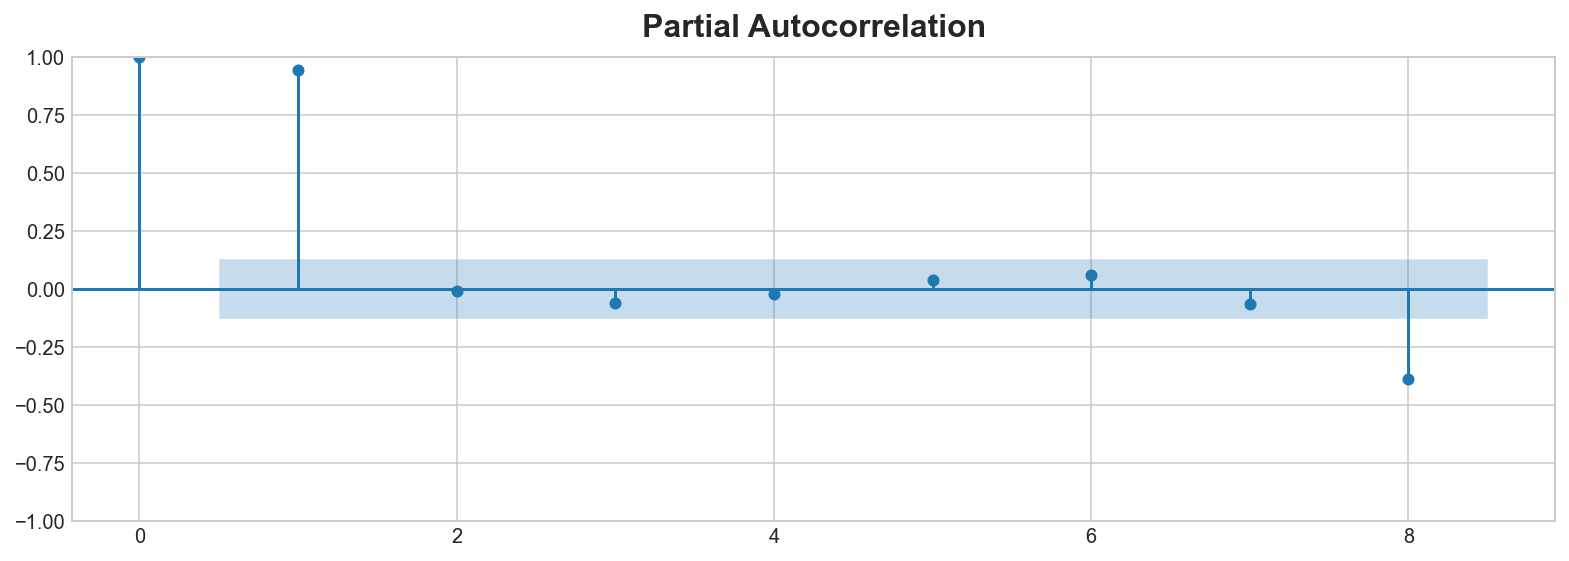

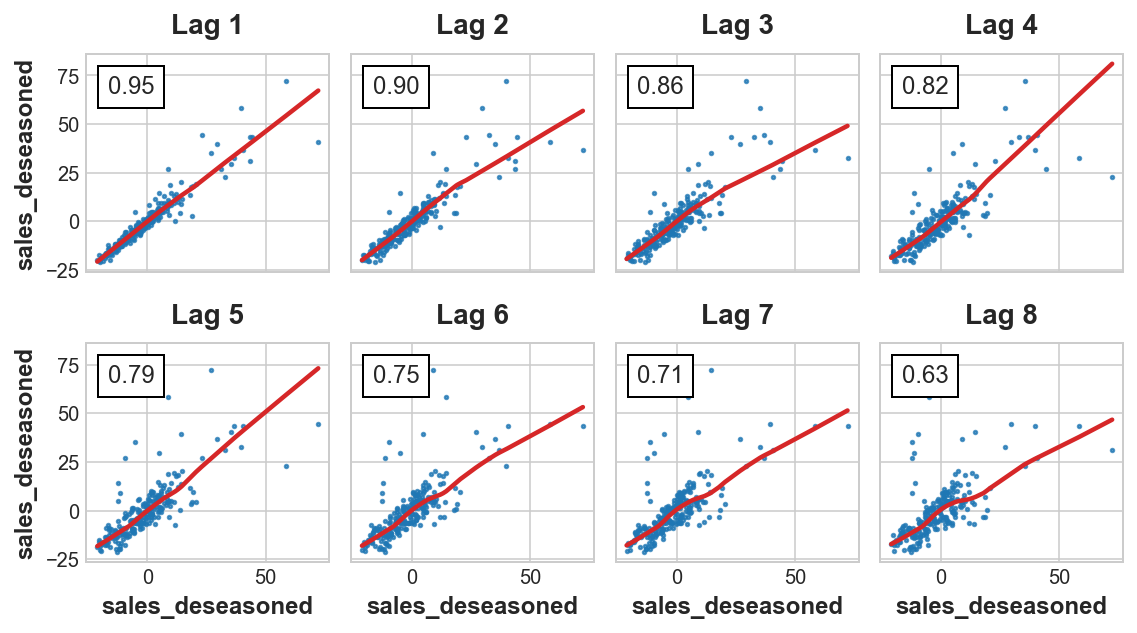

In [152]:
plot_pacf(y_deseason, lags=8)
plot_lags(y_deseason, lags=8, nrows=2);

**Según el correlograma, ¿hay algún lag significativo? ¿El gráfico de lags sugiere alguna relación que no fuera evidente en el correlograma?**

El correlograma indica que el primer lag sea probablemente significativo, así como posiblemente el octavo lag. El gráfico de lag sugiere que el efecto es principalmente lineal.

## Examinando features de series temporales

Ya vimos que un *indicador adelantado* es una serie cuyos valores en un momento dado pueden usarse para predecir el objetivo en un momento futuro. Un indicador adelantado proporciona un aviso anticipado de los cambios en el objetivo.

Nuestro dataset incluye una serie temporal que podría usarse potencialmente como un indicador adelantado, la serie `onpromotion`, que contiene el número de artículos en promoción especial ese día. Dado que la compañía es quien decice cuándo hacer una promoción, no hay que preocuparse por "fuga adelantada" o "fuga de datos". Podríamos usar el valor `onpromotion` del martes para pronosticar las ventas del lunes, por ejemplo.

Vamos a examinar los valores adelantados y lagging de `ompromotion` dibujados contra las ventas de material escolar y de oficina.

In [153]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

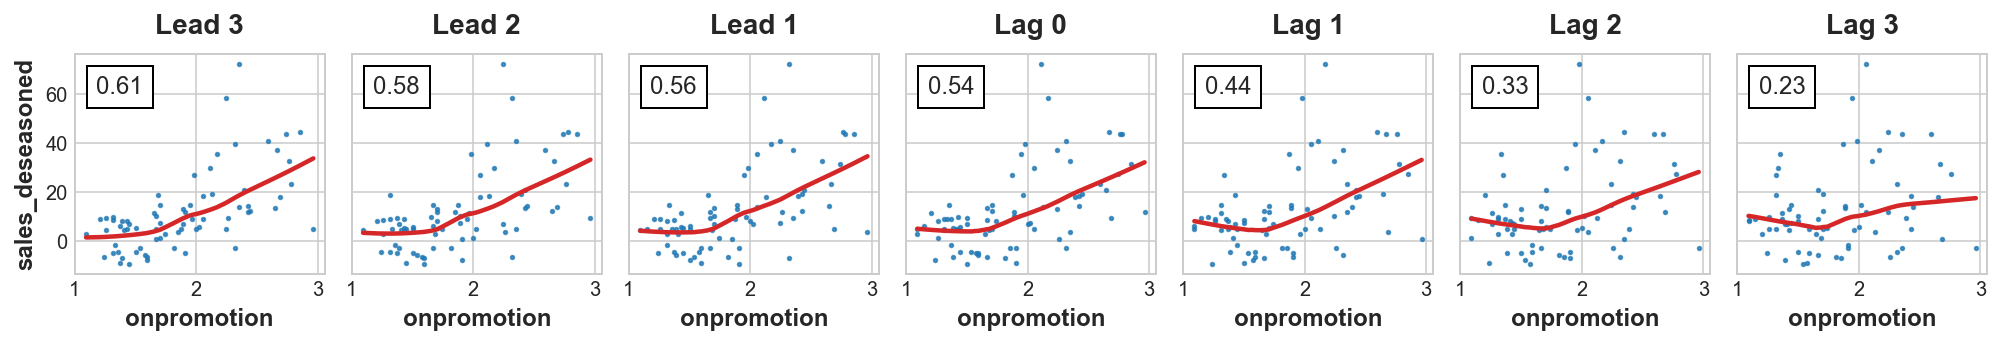

In [154]:

# Elimina los días sin promociones
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

**A tenor del resultado de la gráfica, ¿Podrían ser útiles como features los valores adelantados y lag de onpromotion?**

La gráfica indica que tanto los valores adelantados como los lag de `onpromotion` se correlacionan con las ventas de materiales. Esto sugiere que ambos tipo de valores podrían ser útiles como features. También puede haber algunos efecto no lineales.

## Creación de features de series temporales

Vamos a crear las features indicadas en el apartado anterior.

In [155]:
# genera features a partir de  `y_deseason`
X_lags = make_lags(y_deseason, lags=1)

# genera features a partir de `onpromotion`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Vamos a ver las predicciones del modelo resultante.

Entrenamiento RMSLE: 0.23893
Validación RMSLE: 0.34245


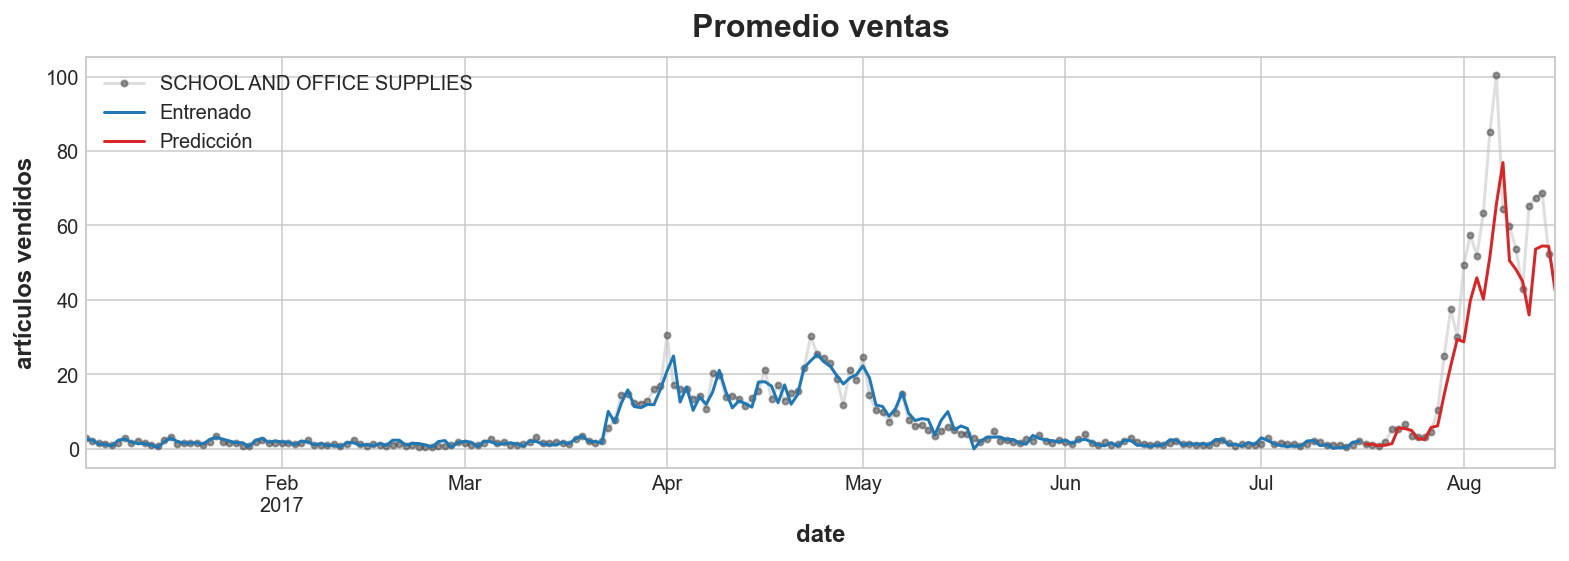

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Entrenamiento RMSLE: {rmsle_train:.5f}')
print(f'Validación RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Promedio ventas", ylabel="artículos vendidos")
ax = y_fit.plot(ax=ax, label="Entrenado", color='C0')
ax = y_pred.plot(ax=ax, label="Predicción", color='C3')
ax.legend();

En los mejores concursos de predicción (Kaggle, etc.) se suelen incluir promedios móviles y otras estadísticas móviles en sus conjuntos de features. Tales variables parecen ser especialmente útiles cuando se usan algoritmos GBDT, como XGBoost.

En otros posts vimos cómo calcular medias móviles para estimar tendencias. Calcular estadísticas móviles para usarse como features es similar excepto que necesitamos tener cuidado para evitar la fuga de datos. En primer lugar, el resultado debe establecerse en el extremo derecho de la ventana, en lugar de en el centro. Es decir, usaremos `center=False` (valor por defecto) en el método `rolling`. En segundo lugar, el objetivo debe estar *lagged* a un paso de tiempo.

## Crear features estadísticas

Ahora vamos a crear las siguientes features:

+ mediana (`median`) móvil de 14 días de lag del objetivo
+ desviación típica (`std`) móvil de 7 días de lag del objetivo
+ suma (`sum`) de 7 días de artículos "en promoción", con ventana centrada

In [157]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# media de 7 días de lagged del objetivo
mean_7 = y_lag.rolling(7).mean()
# media de 14 días de lagged del objetivo
median_14 = y_lag.rolling(14).median()
# desviación típica de 7 días de lagged del objetivo
std_7 = y_lag.rolling(7).std()
# suma de 7 días de promociones con ventana centrada
promo_7 = onpromo.rolling(
    window=7,
    center=True
).sum()

Para calcular más estadísticos podemos acudir a la [documentación de `Window` de Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/window.html). También podemos probar las ventanas "ponderadas exponencialmente" usando `ewm` en lugar de `rolling`; el decaimiento exponencial suele ser una representación más realista de cómo se propagan los efectos en el tiempo.